# Define the transport integrator according to Atoyan et al (1996)

In [286]:
from scipy.integrate import quad

#----------------------------------------
# Define Constants
kpc2cm = 3.08567758e21
m_e = 511e-6 # all units in GeV

def pulsarSpectrum(injSpec, dist, age, diffFunc, gasDens=1.5, w=(.6+.5+.25), power=1e48):
    """
    Implements Atoyan et al 1996 eqn 9-11 and 14-17 for propagation Green function.  
    Energy units are all GeV. 
    
    :param injSpec: Injection spetrum.  Must be function of only the *total energy* in GeV. 
    :param dist: Distance from source in kpc 
    :param age: Age in years
    :param diffFunc: Diffusion rigitidy dependence. Function of only the rigidity.
    :param gasDens: Local Gas number density in units of cm^-3
    :param w: Total Energy loss rate for sync and IC. 0.6 ev/cm^3/s is sync loss for B=5uG, 
                the other two are optical and CMB ISRF
    :param power: Total injected power in erg/s integrated from 1 GeV to 100 TeV 
    :returns energies, local spectrum: 
            energies in GeV and the local spectrum in units [Gev^2 m^-2 s^-1 sr^-1]
    """
    energies = np.logspace(-2,6,250) # Energies to evaluate the spectrum at
    
    # Power  erg*erg2GeV / spectrum normaliation 
    norm = power*624/quad(injSpec, .1, inf,epsrel=1e-20)[0] # integrate up to 100 TeV 
    
    # Convert some units
    t = age*3.15e7
    r = dist*kpc2cm
    
    # Lorentz factor
    gammas = energies/m_e 
    
    # Constants from Sec III
    p0, p1, p2 = 6e-13*gasDens, 1e-15*gasDens, 5.2e-20*w
    gamma_1 = p0/p1
    gamma_2 = p1/p2
    
    nu = p2*(gamma_2-gamma_1)
        
    # Eq. 17
    gamma_t_list = (gammas+gamma_1)/(1-(1-np.exp(-nu*t))*(gammas+gamma_2)/(gamma_2-gamma_1))-gamma_1
    
    # Energy loss eqn 14 # TODO: This needs to be updated to Klein-Nishina regime for gamma>10^5
    P = lambda gamma: p0+p1*gamma+p2*gamma*gamma
    # Integration kernel for Eq. 11
    kernel = lambda gamma: diffFunc(gamma*m_e)/P(gamma)
    
    # looping is slow in python, but the integration step is the longest portion anyway
    # Sacrifice speed for clarity 
    local_spectrum = np.zeros(len(energies))
    for i, gamma in enumerate(gammas): 
        gamma_t = gamma_t_list[i]
        
        # Gamma Cut.  At a certain energy, no propagation, the losses are so strong we cutoff. 
        if gamma_t <= 0:
            gamma_t = 1/(p2*t)
        # No electrons can reach this energy without converting.
        if gamma > 1/(p2*t):
            continue 
        
        # Eqn 10/11 
        r_diff = 2*np.sqrt( quad(kernel, gamma, gamma_t, epsrel=1e-5)[0] ) 
        # return Eq 9 
        local_spectrum[i] = (injSpec(gamma_t*m_e)*P(gamma_t)
                            /(np.pi**1.5*P(gamma)*r_diff**3)*np.exp(-r*r/(r_diff*r_diff)))
        
    # Return the energy and local density* speed of light /solid angle 
    local_spectrum *= norm*3e14/(4*np.pi)
    idx = np.isnan(local_spectrum)
    local_spectrum[idx] = 1e-100
    idx = np.where(local_spectrum==0)[0]
    local_spectrum[idx] = 1e-100
    
    return energies, local_spectrum
    
    


# Test the integrator comparing to Fig 1 of Atoyan et al (1996)

Power law spectrum: $dN/dE \propto E^{-2.2}$ up to $\gamma=E/m_e=10^9$ GeV

Energy dependence of diffusion constant is $D(\mathcal{R})=D_0(1+\mathcal{R}/3~GV)^{0.6}$ with $D_0(10~ \rm{GV})=10^{28}$

Total power $10^{48}$ erg, distance is 100 pc distance, and age is variable.



(0.1, 30000.0)

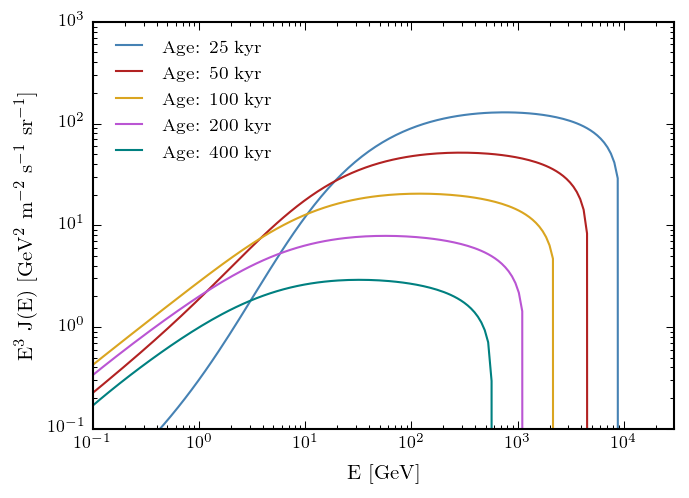

In [331]:
# Should take best fit from "The impact of cosmic ray transport 
# scenarios on the local positron fraction" ICRC 2013 
# Instead just look at benchmark case from Atoyan 1996 and cross-check results 
diffFunc = lambda R: 1e28/2.3*(1+R/3)**0.6 # 
injSpec = lambda E: np.piecewise(E, 
                                 (((E/m_e)<1e9), ((E/m_e)>=1e9)), 
                                 (lambda x: x**-2.2, lambda x: 0.))

# Test propagatio for 5 ages 
for age in [2.5e4,5e4,1e5,2e5,4e5]:
    e, spec = pulsarSpectrum(injSpec, dist=0.1, age=age,
                             diffFunc=diffFunc, gasDens=1.5, w=(.6+.5+.25))
    plt.loglog(e, e**3*spec,label='Age: '+'%1.f'%(age/1e3)+' kyr')

plt.legend(loc=2, frameon=False)
plt.xlabel(r'$\rm{E\ [GeV] }$')
plt.ylabel(r'$\rm{E^3\ J(E)\ [GeV^2\ m^{-2}\ s^{-1}\ sr^{-1}] }$')
plt.ylim(1e-1,1e3)
plt.xlim(1e-1,3e4)




# Variations on Pulsar Parameters

We pick a benchmark scenario at a distance of 250 pc, age of 20 kyr, injection spectrum of 2.2, and cutoff at 5 TeV.  We then consider variations on each of these parameters. 

(0.1, 50000.0)

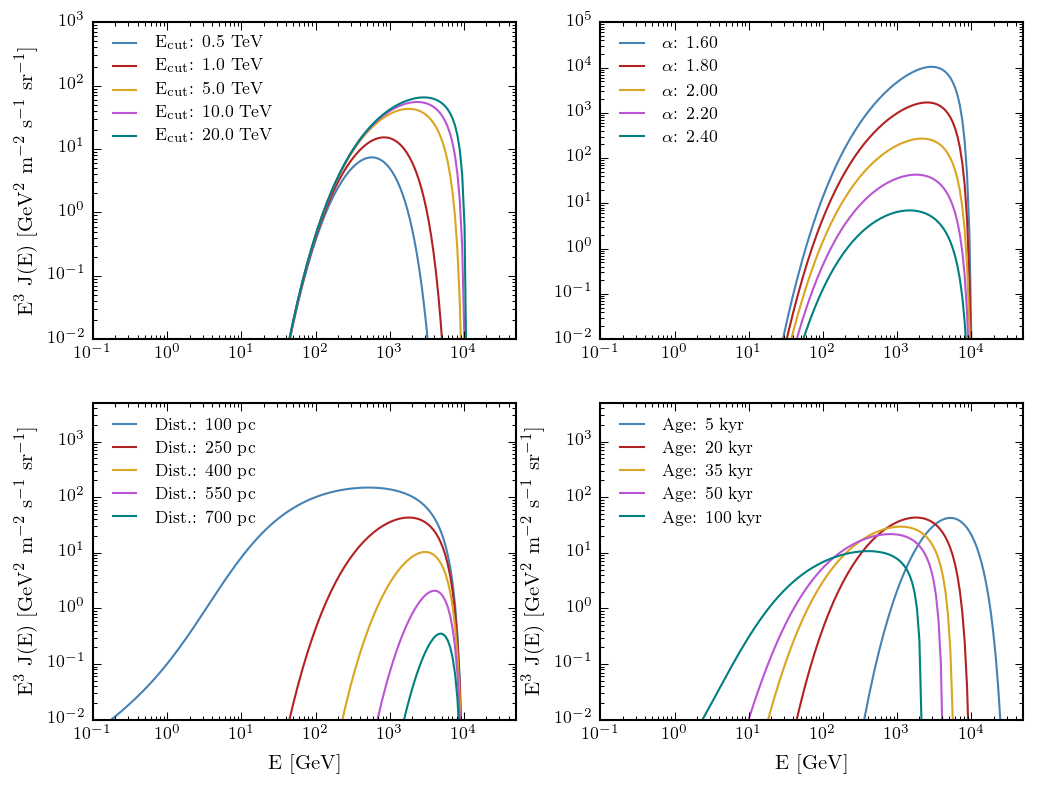

In [337]:
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
# Redefine injection spectrum as a PLExpCutoff with a 10 TeV Cutoff
alpha = 2.2
# Test propagation.
for E_cut in [5e2, 1e3,5e3,10e3,20e3]:
    injSpec = lambda E: E**-2.2*np.exp(-E/E_cut)
    e, spec = pulsarSpectrum(injSpec, dist=0.25, age=2e4, 
                             diffFunc=diffFunc, gasDens=1.5, w=(.6+.5+.25))
    plt.loglog(e, e**3*spec,label=r'E$_{\rm cut}$: '+'%1.1f'%(E_cut/1e3)+' TeV')

    
plt.legend(loc=2, frameon=False, fontsize=8)
plt.ylabel(r'$\rm{E^3\ J(E)\ [GeV^2\ m^{-2}\ s^{-1}\ sr^{-1}] }$')
#plt.text(0.2,0.08, r'PLExpCut Vary ${\rm E_{cut}}$', transform=plt.gca().transAxes, fontsize=10)
plt.ylim(1e-2,1e3)
plt.xlim(1e-1,5e4)


plt.subplot(2,2,2)
# Redefine injection spectrum as a PLExpCutoff with a 10 TeV Cutoff
# Test propagation.
for alpha in [1.6,1.8,2.,2.2,2.4]:
    injSpec = lambda E: E**-alpha*np.exp(-E/5e3)
    e, spec = pulsarSpectrum(injSpec, dist=0.25, age=2e4, 
                             diffFunc=diffFunc, gasDens=1.5, w=(.6+.5+.25))
    plt.loglog(e, e**3*spec,label=r'$\alpha$: '+'%1.2f'%(alpha))
plt.legend(loc=2, frameon=False, fontsize=8)


plt.ylim(1e-2,1e5)
plt.xlim(1e-1,5e4)


plt.subplot(2,2,3)
# Redefine injection spectrum as a PLExpCutoff with a 10 TeV Cutoff
alpha = 2.2
# Test propagation.
for dist in [.100,.250,.400,.550,.700]:
    injSpec = lambda E: E**-2.2*np.exp(-E/5e3)
    e, spec = pulsarSpectrum(injSpec, dist=dist, age=2e4, 
                             diffFunc=diffFunc, gasDens=1.5, w=(.6+.5+.25))
    plt.loglog(e, e**3*spec,label=r'Dist.: '+'%.0f'%(dist*1e3)+' pc')
plt.legend(loc=2, frameon=False, fontsize=8)

plt.xlabel(r'$\rm{E\ [GeV] }$')
plt.ylabel(r'$\rm{E^3\ J(E)\ [GeV^2\ m^{-2}\ s^{-1}\ sr^{-1}] }$')
plt.ylim(1e-2,5e3)
plt.xlim(1e-1,5e4)



plt.subplot(2,2,4)
# Redefine injection spectrum as a PLExpCutoff with a 10 TeV Cutoff
alpha = 2.2
# Test propagation.
for age in [0.5e4,2e4,3.5e4,5e4,1e5]:
    injSpec = lambda E: E**-2.2*np.exp(-E/5e3)
    e, spec = pulsarSpectrum(injSpec, dist=0.25, age=age, 
                             diffFunc=diffFunc, gasDens=1.5, w=(.6+.5+.25))
    plt.loglog(e, e**3*spec,label=r'Age: '+'%.0f'%(age/1e3)+' kyr')
plt.legend(loc=2, frameon=False, fontsize=8)

plt.xlabel(r'$\rm{E\ [GeV] }$')
plt.ylabel(r'$\rm{E^3\ J(E)\ [GeV^2\ m^{-2}\ s^{-1}\ sr^{-1}] }$')
plt.ylim(1e-2,5e3)
plt.xlim(1e-1,5e4)

